In [1]:
import warnings

warnings.filterwarnings(
    'ignore', '.*This code is currently UNREVIEWED, use with caution!.*'
)

In [2]:
import astropy.units as u
import lalsimulation.gwsignal.core.waveform as wfm
import matplotlib.pyplot as plt
import numpy as np

from gw_signal_tools.waveform import inner_product, norm
from gw_signal_tools.PSDs import psd_gw150914

/Users/maxmelching/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.


In [3]:
from gw_signal_tools import PLOT_STYLE_SHEET

plt.style.use(PLOT_STYLE_SHEET)

# Inner Product Tests

In [4]:
# Define the dictionary
f_min = 15.0 * u.Hz
f_max = 1024.0 * u.Hz

wf_params = {
    'mass1': 36 * u.solMass,
    'mass2': 29 * u.solMass,
    'deltaT': 1.0 / 2048.0 * u.s,
    'deltaF': 2**-8 * u.Hz,
    'f22_start': f_min,
    'f_max': f_max,
    'f22_ref': 20.0 * u.Hz,
    'phi_ref': 0.0 * u.rad,
    'distance': 440.0 * u.Mpc,
    'condition': 1,  # NEED THIS for consistent comparison of time domain and frequency domain waveforms
}

# Define the approximant
approximant = 'IMRPhenomXPHM'

# Call the generator
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)


# Generate time domain waveform
hp_t, hc_t = wfm.GenerateTDWaveform(wf_params, gen)

# Two waveforms will be generated in frequency domain, first with finer
# sampling and then with coarser one
hp_f_fine, hc_f_fine = wfm.GenerateFDWaveform(wf_params, gen)
hp_f_fine.override_unit(u.s)
hc_f_fine.override_unit(u.s)

## Match Testing

If you have looked at the `inner_product_tutorial` notebook, then you have probably stumbled upon this computation.

In [13]:
time_shift = 0.5 * u.s
phase_shift = 0.8 * u.rad

hp_f_fine_shifted = hp_f_fine * np.exp(
    -2.0j * np.pi * hp_f_fine.frequencies * time_shift + 1.0j * phase_shift
)

overlap_fine, info = inner_product(
    hp_f_fine_shifted,
    hp_f_fine,
    psd_gw150914,
    optimize_time_and_phase=True,
    return_opt_info=True,
)

time = info['peak_time']
phase = info['peak_phase']
match_series = info['match_series']

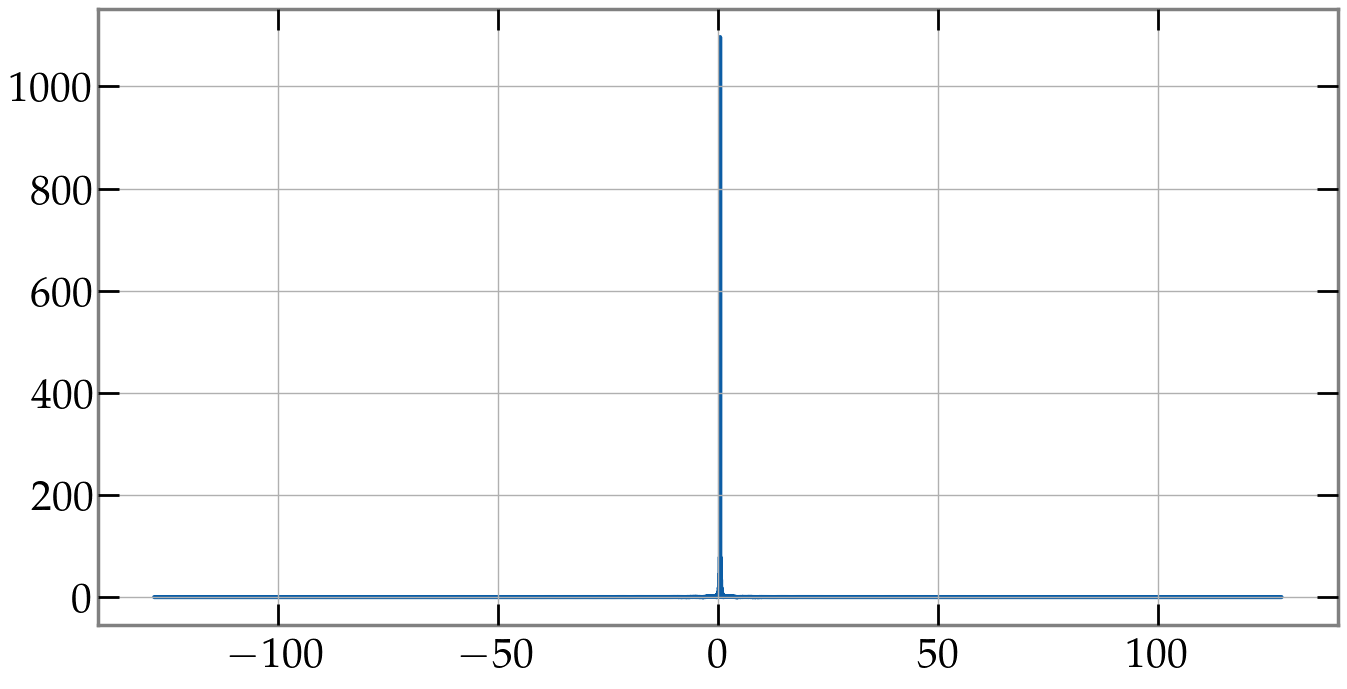

In [14]:
plt.figure(figsize=(16, 8))

plt.plot(match_series.abs())

# plt.xlim(-1, 1)

plt.show()

In [ ]:
print(
    f'Match value is {overlap_fine**0.5:.5f}, norm is {norm(hp_f_fine, psd_gw150914):.5f}'
)
print(f'Calculated time shift: {time:.5f}, applied time shift: {time_shift:.5f}')
print(
    f'Difference is t_peak - t_shift = {time - time_shift:.5f}, while resolution is {match_series.dt:.5f}'
)
print(f'Calculated phase shift: {phase:.5f}, applied phase shift: {phase_shift:.5f}')

Inner product value is 33.11366 1 / strain, norm is 33.11356 1 / strain
Calculated time shift: 0.50000 s, applied time shift: 0.50000 s
Difference is t_peak - t_shift = 0.00000 s, while resolution is 0.00049 s
Calculated phase shift: 0.80000 rad, applied phase shift: 0.80000 rad


We had noted that this all of these values agree really well with our expectations.

But what was left unaddressed in the other notebook (and that you might wonder about) is the way that this time shift is performed.
Nominally, shifting is more intuitive in time domain - but this is a little different for Fourier transforms when it comes to the `lal` implementation.
Let's look at what that means.

In [16]:
from gw_signal_tools.waveform import td_to_fd, pad_to_dx

time_shift = 2.0 * u.s
phase_shift = 0.0 * u.rad

hp_t_shifted = pad_to_dx(
    hp_t, dx=2**-6 * u.Hz
).copy()  # Padding for better resolution after FT
hp_t_shifted.times += time_shift
hp_t_shifted = hp_t_shifted * np.exp(1.0j * phase_shift)

match_val, match_info = inner_product(
    td_to_fd(hp_t_shifted),
    td_to_fd(hp_t),
    psd=psd_gw150914,
    optimize_time_and_phase=True,
    return_opt_info=True,
)
peak_time = match_info['peak_time']
peak_phase = match_info['peak_phase']
match_series = match_info['match_series']

2025-12-20  19:32:56  INFO (utils.py: 424): Upper bound 1023.875 1 / s in `fill_bounds` is larger than the signals end upper xindex bound 1023.7921234267154 1 / s. Please be aware that this function does nothing to change that, i.e. no padding is applied.
2025-12-20  19:32:56  INFO (utils.py: 424): Upper bound 1023.875 1 / s in `fill_bounds` is larger than the signals end upper xindex bound 1023.7921234267154 1 / s. Please be aware that this function does nothing to change that, i.e. no padding is applied.
2025-12-20  19:32:56  INFO (utils.py: 424): Upper bound 1023.875 Hz in `fill_bounds` is larger than the signals end upper xindex bound 1023.7921234267154 Hz. Please be aware that this function does nothing to change that, i.e. no padding is applied.


In [ ]:
print(
    f'Match value is {match_val**0.5:.5f}, norm is {norm(hp_t_shifted, psd_gw150914):.5f}'
)
print(f'Calculated time shift: {peak_time:.5f}, applied time shift: {time_shift:.5f}')
print(
    f'Difference is t_peak - t_shift = {peak_time - time_shift:.5f}, while resolution is {match_series.dt:.5f}'
)
print(
    f'Calculated phase shift: {peak_phase:.5f}, applied phase shift: {phase_shift:.5f}'
)

2025-12-20  19:32:56  INFO (inner_product.py: 257): `signal1` is a ``TimeSeries``, performing an automatic FFT. Due to potential issues with conventions and resolution of the result, this is discouraged, consider doing it manually.
2025-12-20  19:32:56  INFO (inner_product.py: 266): `signal2` is a ``TimeSeries``, performing an automatic FFT. Due to potential issues with conventions and resolution of the result, this is discouraged, consider doing it manually.


Inner product value is 33.11806 1 / strain, norm is 33.11394 1 / strain
Calculated time shift: 0.00000 s, applied time shift: 2.00000 s
Difference is t_peak - t_shift = -2.00000 s, while resolution is 0.00029 s
Calculated phase shift: -0.00000 rad, applied phase shift: 0.00000 rad


A time shift of zero is inferred here, which is precisely due to the way that `lal` and `gwsignal` handles time shifts in the context of Fourier transforms.
(Which also explains why time shifts are more easily performed in frequency domain in the `gwsignal` convention.)

In "the other" convention, where time shifts are imprinted on frequency domain signals, we can shift in the usual manner with the expected effect.

In [18]:
from gw_signal_tools.waveform import td_to_fd, pad_to_dx

time_shift = 2.0 * u.s
phase_shift = 0.0 * u.rad

hp_t_shifted = pad_to_dx(
    hp_t, dx=hp_f_fine.df
).copy()  # Padding for better resolution after FT
hp_t_shifted.times += time_shift
hp_t_shifted = hp_t_shifted * np.exp(1.0j * phase_shift)

match_val, match_info = inner_product(
    td_to_fd(hp_t_shifted, convention='unwrap'),
    td_to_fd(hp_t, convention='unwrap'),
    psd=psd_gw150914,
    optimize_time_and_phase=True,
    return_opt_info=True,
)
peak_time = match_info['peak_time']
peak_phase = match_info['peak_phase']
match_series = match_info['match_series']

2025-12-20  19:32:56  INFO (utils.py: 424): Upper bound 1023.875 1 / s in `fill_bounds` is larger than the signals end upper xindex bound 1023.7921234267154 1 / s. Please be aware that this function does nothing to change that, i.e. no padding is applied.
2025-12-20  19:32:56  INFO (utils.py: 424): Upper bound 1023.875 1 / s in `fill_bounds` is larger than the signals end upper xindex bound 1023.7921234267154 1 / s. Please be aware that this function does nothing to change that, i.e. no padding is applied.
2025-12-20  19:32:56  INFO (utils.py: 424): Upper bound 1023.875 Hz in `fill_bounds` is larger than the signals end upper xindex bound 1023.7921234267154 Hz. Please be aware that this function does nothing to change that, i.e. no padding is applied.


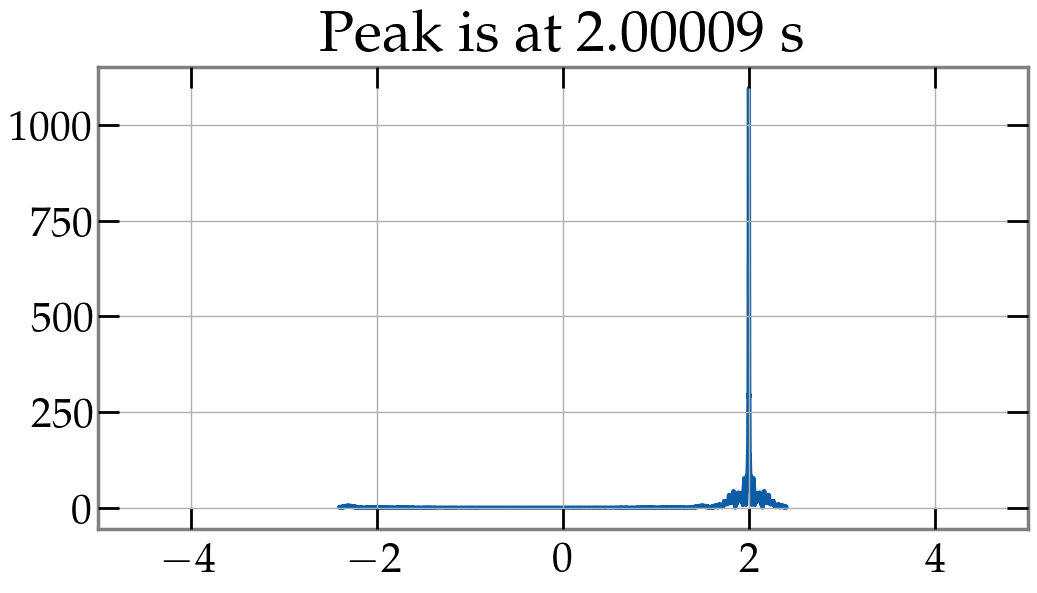

In [19]:
f, ax = plt.subplots(figsize=(12, 6))

ax.plot(match_series.abs())

ax.set_title(f'Peak is at {peak_time:.5f}')

ax.set_xlim([-5, 5])
# ax.set_xlim([-2.5, -1.5])

plt.show()

In [ ]:
print(
    f'Match value is {match_val**0.5:.5f}, norm is {norm(hp_t_shifted, psd_gw150914):.5f}'
)
print(f'Calculated time shift: {peak_time:.5f}, applied time shift: {time_shift:.5f}')
print(
    f'Difference is t_peak - t_shift = {peak_time - time_shift:.5f}, while resolution is {match_series.dt:.5f}'
)
print(
    f'Calculated phase shift: {peak_phase:.5f}, applied phase shift: {phase_shift:.5f}'
)

2025-12-20  19:32:56  INFO (inner_product.py: 257): `signal1` is a ``TimeSeries``, performing an automatic FFT. Due to potential issues with conventions and resolution of the result, this is discouraged, consider doing it manually.
2025-12-20  19:32:56  INFO (inner_product.py: 266): `signal2` is a ``TimeSeries``, performing an automatic FFT. Due to potential issues with conventions and resolution of the result, this is discouraged, consider doing it manually.


Inner product value is 33.10358 1 / strain, norm is 33.11344 1 / strain
Calculated time shift: 2.00009 s, applied time shift: 2.00000 s
Difference is t_peak - t_shift = 0.00009 s, while resolution is 0.00029 s
Calculated phase shift: 0.06694 rad, applied phase shift: 0.00000 rad


There is some residual difference in the time shift, but we cannot resolve it with the given signals.
This "resolution" is determined by the sample size of the signals and the spacing between their samples.
As such, it is a parameter we can control.
In the `inner_product` function, the corresponding parameter is named `min_dt_prec`.

In [21]:
match_val, match_info = inner_product(
    td_to_fd(hp_t_shifted, convention='unwrap'),
    td_to_fd(hp_t, convention='unwrap'),
    psd=psd_gw150914,
    optimize_time_and_phase=True,
    return_opt_info=True,
    min_dt_prec=1e-5 * u.s,
)
peak_time = match_info['peak_time']
peak_phase = match_info['peak_phase']
match_series = match_info['match_series']

2025-12-20  19:32:56  INFO (utils.py: 424): Upper bound 1023.875 1 / s in `fill_bounds` is larger than the signals end upper xindex bound 1023.7921234267154 1 / s. Please be aware that this function does nothing to change that, i.e. no padding is applied.
2025-12-20  19:32:56  INFO (utils.py: 424): Upper bound 1023.875 1 / s in `fill_bounds` is larger than the signals end upper xindex bound 1023.7921234267154 1 / s. Please be aware that this function does nothing to change that, i.e. no padding is applied.
2025-12-20  19:32:56  INFO (utils.py: 424): Upper bound 1023.875 Hz in `fill_bounds` is larger than the signals end upper xindex bound 1023.7921234267154 Hz. Please be aware that this function does nothing to change that, i.e. no padding is applied.


In [ ]:
print(
    f'Match value is {match_val**0.5:.5f}, norm is {norm(hp_t_shifted, psd_gw150914):.5f}'
)
print(f'Calculated time shift: {peak_time:.5f}, applied time shift: {time_shift:.5f}')
print(
    f'Difference is t_peak - t_shift = {peak_time - time_shift:.5f}, while resolution is {match_series.dt:.5f}'
)
print(
    f'Calculated phase shift: {peak_phase:.5f}, applied phase shift: {phase_shift:.5f}'
)

2025-12-20  19:32:56  INFO (inner_product.py: 257): `signal1` is a ``TimeSeries``, performing an automatic FFT. Due to potential issues with conventions and resolution of the result, this is discouraged, consider doing it manually.
2025-12-20  19:32:56  INFO (inner_product.py: 266): `signal2` is a ``TimeSeries``, performing an automatic FFT. Due to potential issues with conventions and resolution of the result, this is discouraged, consider doing it manually.


Inner product value is 33.11504 1 / strain, norm is 33.11344 1 / strain
Calculated time shift: 2.00000 s, applied time shift: 2.00000 s
Difference is t_peak - t_shift = -0.00000 s, while resolution is 0.00001 s
Calculated phase shift: -0.00269 rad, applied phase shift: 0.00000 rad


As expected, the difference between calculated and inferred time shift is now below our desired resolution of $10^{-5}$.

interesting side effect: phase more accurately inferred, too

### More on `min_dt_prec`

In [37]:
time_shift = -0.2 * u.s
phase_shift = 0.12 * u.rad

# NOTE: for reference norm, we will use finely sampled waveform
norm_fine = norm(hp_f_fine) ** 2  # Non-optimized


for df in [2**-2 * u.Hz, 2**-4 * u.Hz, 2**-6 * u.Hz]:
    hf, _ = wfm.GenerateFDWaveform(wf_params | {'deltaF': df}, gen)

    for dt in [None, 1e-4 * u.s, 1e-6 * u.s]:
        hf_shifted = hf * np.exp(
            -2.0j * np.pi * hf.frequencies * time_shift + 1.0j * phase_shift
        )
        overlap_fine, info_fine = inner_product(
            hf_shifted,
            hf,
            optimize_time_and_phase=True,
            return_opt_info=True,
            min_dt_prec=dt,
            df=df,
        )
        peak_time = info_fine['peak_time']
        peak_phase = info_fine['peak_phase']
        match_series = info_fine['match_series']

        print(f'Testing {df = :.2e}, min_dt_prec = {dt}')
        print(f'Match value is {overlap_fine}, norm is {norm_fine}')
        # print(norm_fine, overlap_fine, abs(norm_fine.value - overlap_fine.value)/norm_fine.value)
        print(f'Calculated time shift: {peak_time}, applied time shift: {time_shift}')
        # print(f'Difference is t_peak - t_shift = {peak_time - time_shift:.5f}, while resolution is {match_series.dt:.5f}')
        print(
            f'Calculated phase shift: {peak_phase}, applied phase shift: {phase_shift}'
        )
        print(80 * '-')

Testing df = 2.50e-01 Hz, min_dt_prec = None
Match value is 5.538843969353482e-43 1 / (s2 strain2), norm is 5.54279400023223e-43 1 / strain2
Calculated time shift: -0.199951171875 s, applied time shift: -0.2 s
Calculated phase shift: 0.13147969549437946 rad, applied phase shift: 0.12 rad
--------------------------------------------------------------------------------
Testing df = 2.50e-01 Hz, min_dt_prec = 0.0001 s
Match value is 5.539264703364162e-43 1 / (s2 strain2), norm is 5.54279400023223e-43 1 / strain2
Calculated time shift: -0.20001220703125 s, applied time shift: -0.2 s
Calculated phase shift: 0.11712980192145414 rad, applied phase shift: 0.12 rad
--------------------------------------------------------------------------------
Testing df = 2.50e-01 Hz, min_dt_prec = 1e-06 s
Match value is 5.539292751397269e-43 1 / (s2 strain2), norm is 5.54279400023223e-43 1 / strain2
Calculated time shift: -0.19999980926513672 s, applied time shift: -0.2 s
Calculated phase shift: 0.1200448471

careful not to increase df and min_dt_prec simultaneously, means arrays we deal with during calculation become huge -> look for sweetspot


Sweetspot: generation df of 2**-2, calculation df of 2**-2, calculation min_dt_prec of 1e-5. Has relative error below 1% (around 0.8% for norm squared, around 0.5% for norm) compared to norm of waveform that is generated at high df and then integrated using Simpson (or even IFFT method with very small df, min_dt_prec).

Interesting: calculation using full spectrum is much more accurate

Very interesting: even for a spacing of 4 (!) Hz, the correct time and phase shift are inferred to really good accuracy as long as we make min_dt_prec sufficiently small (1e-5 was typically small enough). This does increase error in integration result, i.e. overlap in this case, but otherwise a change of sampling and integration $df$ (should be the same I suppose for real test at this resolution, otherwise interpolation plays a role) has only very little effect.

## Overlap Optimization

Can also optimize inner products over more general parameters

In [24]:
from gw_signal_tools.waveform import optimize_overlap

In [25]:
hf, _ = wfm.GenerateFDWaveform(wf_params, gen)

h_symm = hf  # For real fft testing

# h_symm = FrequencySeries(
#     np.flip(np.conjugate(hf)[1:]),  # Exclude zero component
#     f0=-hf.frequencies[-1],
#     df=hf.df,
#     unit=hf.unit
# ).append(hf, inplace=True)  # For complex fft testing with odd sample size
# ).append(hf[:-1], inplace=True)  # For complex fft testing with even sample size


time_shift = -0.2 * u.s
phase_shift = 0.12 * u.rad
# Hardest combination in previous tests


def wf_gen(wf_params):
    return wfm.GenerateFDWaveform(wf_params, gen)[0] * u.s


def wf_gen_shifted(wf_params):
    wf = wfm.GenerateFDWaveform(wf_params, gen)[0] * u.s
    return wf * np.exp(-2.0j * np.pi * wf.frequencies * time_shift + 1.0j * phase_shift)


for dt in [None, 1e-4 * u.s, 1e-5 * u.s, 1e-6 * u.s]:
    # for dt in [1e-5*u.s]:
    wf1, wf2, info_fine = optimize_overlap(
        wf_params,
        # wf_params | {'deltaF': 2**-2*u.Hz},
        wf_gen_shifted,
        wf_gen,
        opt_params=['time', 'phase'],
        # opt_params=['time', 'psi'],
        # optimize_time_and_phase=True,
        # return_opt_info=True,
        min_dt_prec=dt,
        df=2**-2,
    )

    print(info_fine)

2025-12-20  19:32:57  INFO (inner_product.py: 1194): Optimization was conducted successfully. Remaining waveform mismatch is 0.00008.


{'time': <Quantity -0.19995117 s>, 'phase': <Quantity 0.13147522 rad>}


2025-12-20  19:32:57  INFO (inner_product.py: 1194): Optimization was conducted successfully. Remaining waveform mismatch is 0.00001.


{'time': <Quantity -0.20001221 s>, 'phase': <Quantity 0.11713092 rad>}


2025-12-20  19:32:57  INFO (inner_product.py: 1194): Optimization was conducted successfully. Remaining waveform mismatch is 0.00000.


{'time': <Quantity -0.19999695 s>, 'phase': <Quantity 0.12071727 rad>}


2025-12-20  19:32:58  INFO (inner_product.py: 1194): Optimization was conducted successfully. Remaining waveform mismatch is 0.00000.


{'time': <Quantity -0.19999981 s>, 'phase': <Quantity 0.12004483 rad>}
